## Creating Dataset for Models

### 1.Dataset from Floating Car Data and Collision Data

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
from xml.etree import ElementTree as ET
import pandas as pd
import seaborn as sns
import numpy as np

In [34]:
fcd_tree = ET.parse('output/fcd_op.xml')
fcd_root = fcd_tree.getroot()

collisions_tree = ET.parse('output/collisions.xml')
collisions_root = collisions_tree.getroot()

print("FCD XML Structure:")
for child in fcd_root:
    print(child.tag, child.attrib)
    for grandchild in child:
        print("  ", grandchild.tag, grandchild.attrib)
    break 

print("\nCollisions XML Structure:")
for child in collisions_root:
    print(child.tag, child.attrib)
    break 

FCD XML Structure:
timestep {'time': '0.00'}
   vehicle {'id': 'myflow.0', 'x': '-94.90', 'y': '-4.80', 'angle': '90.00', 'type': 'normal', 'speed': '0.00', 'pos': '5.10', 'lane': 'E0_0', 'slope': '0.00', 'signals': '0', 'acceleration': '0.00', 'distance': '5.10'}

Collisions XML Structure:
collision {'time': '15.80', 'type': 'collision', 'lane': 'E0_1', 'pos': '77.55', 'collider': 'myflow.2', 'victim': 'myflow.1', 'colliderType': 'aggressive', 'victimType': 'aggressive', 'colliderSpeed': '3.83', 'victimSpeed': '0.00'}


In [35]:
fcd_data = []
collisions_data = []

for timestep in fcd_root:
    time = float(timestep.attrib['time'])
    for vehicle in timestep:
        vehicle_data = {'time': time}
        vehicle_data.update(vehicle.attrib)
        fcd_data.append(vehicle_data)

for collision in collisions_root:
    collision_data = collision.attrib
    collision_data['time'] = float(collision_data['time'])
    collisions_data.append(collision_data)

fcd_df = pd.DataFrame(fcd_data)
collisions_df = pd.DataFrame(collisions_data)

numeric_cols = ['time', 'x', 'y', 'angle', 'speed', 'pos', 'slope', 'acceleration', 'distance']
fcd_df[numeric_cols] = fcd_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

fcd_df.to_csv('output_fcd.csv', index=False)
collisions_df.to_csv('output_collision.csv', index=False)

In [36]:
collision_data = pd.read_csv("output_collision.csv")
fcd_data = pd.read_csv("output_fcd.csv")

fcd_data['collision_type'] = 'No collision'
fcd_data['collision_occurred'] = 0
fcd_data['InvolvedParties'] = 'Not involved'

def match_and_update(fcd_row):
    matching_rows = collision_data[
        (collision_data['time'] == fcd_row['time']) &
        (collision_data['collider'] == fcd_row['id']) &
        (collision_data['pos'] == fcd_row['pos']) &
        (collision_data['colliderType'] == fcd_row['type']) &
        (collision_data['colliderSpeed'] == fcd_row['speed'])
    ]
    
    matching_rows_vic = collision_data[
        (collision_data['time'] == fcd_row['time']) &
        (collision_data['victim'] == fcd_row['id']) &
        (collision_data['victimType'] == fcd_row['type']) &
        (collision_data['victimSpeed'] == fcd_row['speed'])
    ]
    
    if not matching_rows.empty:
        first_match = matching_rows.iloc[0]
        fcd_data.at[fcd_row.name, 'collision_type'] = first_match['type']
        fcd_data.at[fcd_row.name, 'collision_occurred'] = 1
        fcd_data.at[fcd_row.name, 'InvolvedParties'] = 'collider'
    
    if not matching_rows_vic.empty:
        first_match = matching_rows_vic.iloc[0]
        fcd_data.at[fcd_row.name, 'collision_type'] = first_match['type']
        fcd_data.at[fcd_row.name, 'collision_occurred'] = 1
        fcd_data.at[fcd_row.name, 'InvolvedParties'] = 'victim'

fcd_data.apply(match_and_update, axis=1)
fcd_data["collision_type"] = fcd_data["collision_type"].replace('collision', 'lane')
fcd_data['lane'] = fcd_data['lane'].str.replace(':', '').str.replace('=', '')
fcd_data.to_csv('dataset_fcd_col.csv', index=False)
fcd_data.head()

,time,id,x,y,angle,type,speed,pos,lane,slope,signals,acceleration,distance,collision_type,collision_occurred,InvolvedParties
0,0.0,myflow.0,-94.90,-4.8,90.0,normal,0.00,5.10,E0_0,0.0,0,0.00,5.10,No collision,0,Not involved
1,0.1,myflow.0,-94.90,-4.8,90.0,normal,0.01,5.10,E0_0,0.0,8,0.15,5.10,No collision,0,Not involved
2,0.2,myflow.0,-94.89,-4.8,90.0,normal,0.04,5.11,E0_0,0.0,8,0.28,5.11,No collision,0,Not involved
3,0.3,myflow.0,-94.89,-4.8,90.0,normal,0.09,5.11,E0_0,0.0,8,0.49,5.11,No collision,0,Not involved
4,0.4,myflow.0,-94.87,-4.8,90.0,normal,0.17,5.13,E0_0,0.0,0,0.81,5.13,No collision,0,Not involved


### FCD-Collision time-series dataset

In [132]:
dataset_fcd = pd.read_csv("dataset_fcd_col.csv")
dataset_fcd.describe()

,time,x,y,angle,speed,pos,slope,signals,acceleration,distance,collision_occurred
count,39797.000000,39797.000000,39797.000000,39797.000000,39797.000000,39797.000000,39797.0,39797.000000,39797.000000,39797.000000,39797.000000
mean,217.352841,-4.854745,2.196552,98.960255,4.336417,55.120543,0.0,4.767596,0.286229,66.157387,0.000452
std,110.223915,28.445291,33.006073,91.356693,5.144260,51.491980,0.0,4.326233,1.472601,29.344317,0.021263
min,0.000000,-99.760000,-94.900000,0.000000,0.000000,0.000000,0.0,0.000000,-7.000000,0.000000,0.000000
25%,128.800000,-11.490000,-1.600000,0.000000,0.000000,18.940000,0.0,0.000000,-0.040000,47.340000,0.000000
50%,214.700000,-0.940000,-1.600000,90.000000,1.490000,68.800000,0.0,3.000000,0.000000,79.240000,0.000000
75%,310.100000,4.800000,10.210000,180.000000,8.870000,83.740000,0.0,10.000000,0.820000,88.510000,0.000000
max,428.900000,99.890000,99.890000,270.000000,20.660000,8049.000000,0.0,11.000000,10.220000,110.370000,1.000000


### Dataset Analysis

### 1. Collision data analysis

In [4]:
filtered_data = dataset_fcd[(dataset_fcd['collision_occurred'] == 1) & (dataset_fcd['InvolvedParties'] == 'collider')]
x_coords = filtered_data['x']
y_coords = filtered_data['y']
filtered_data

,time,id,x,y,angle,type,speed,pos,lane,slope,signals,acceleration,distance,collision_type,collision_occurred,InvolvedParties
394,15.8,myflow.2,-22.45,-1.60,90.00,aggressive,3.83,77.55,E0_1,0.0,10,-7.00,77.55,lane,1,collider
2180,42.4,myflow.8,4.80,1.36,0.00,violator,3.70,11.76,J2_9_0,0.0,8,-2.20,101.36,junction,1,collider
5875,85.8,myflow.19,-1.60,24.31,180.00,violator,4.60,75.69,E2_1,0.0,10,-5.82,75.69,lane,1,collider
6526,91.9,myflow.21,4.80,-23.78,0.00,aggressive,1.28,76.22,-E3_0,0.0,8,-6.59,76.22,lane,1,collider
11448,144.9,myflow.27,-1.49,1.34,62.36,aggressive,6.14,4.56,J2_19_0,0.0,2,5.09,99.17,junction,1,collider
13869,167.0,myflow.40,1.60,-21.33,0.00,aggressive,3.53,78.67,-E3_1,0.0,8,-3.44,78.67,lane,1,collider
18299,201.7,myflow.49,-41.58,-1.60,90.00,aggressive,2.12,58.42,E0_1,0.0,10,-2.78,58.42,lane,1,collider
29607,307.3,myflow.75,-33.57,-1.60,90.00,aggressive,1.62,66.43,E0_1,0.0,10,-6.99,66.43,lane,1,collider
31105,322.9,myflow.78,-1.60,16.53,180.00,violator,1.49,83.47,E2_1,0.0,10,-6.99,83.47,lane,1,collider


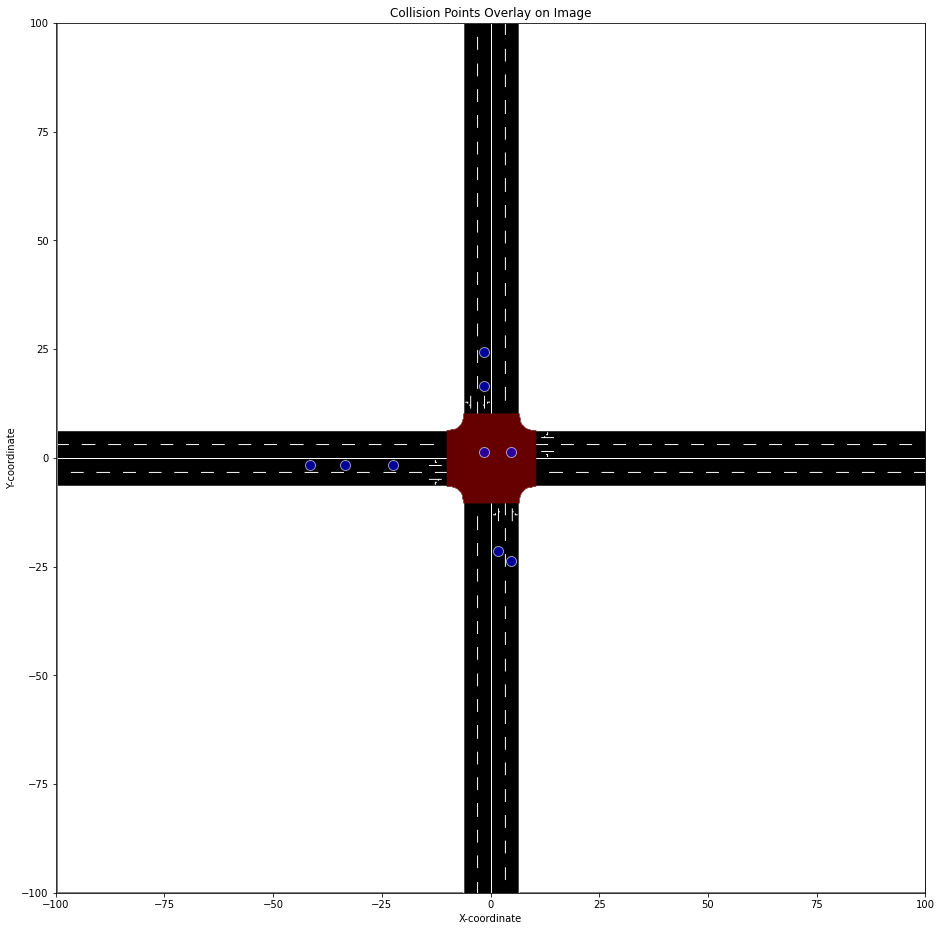

In [5]:
image_path = "intersec_try.png"
new_image = mpimg.imread(image_path)
fig, ax = plt.subplots(figsize=(16,16))
extent_centered = [-100, 100, -100, 100]
ax.imshow(new_image, extent=extent_centered)
ax.scatter(x_coords, y_coords, marker='o', color='blue', s=100, alpha=0.6, edgecolors='w', linewidths=1)
ax.set_title("Collision Points Overlay on Image")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.show()

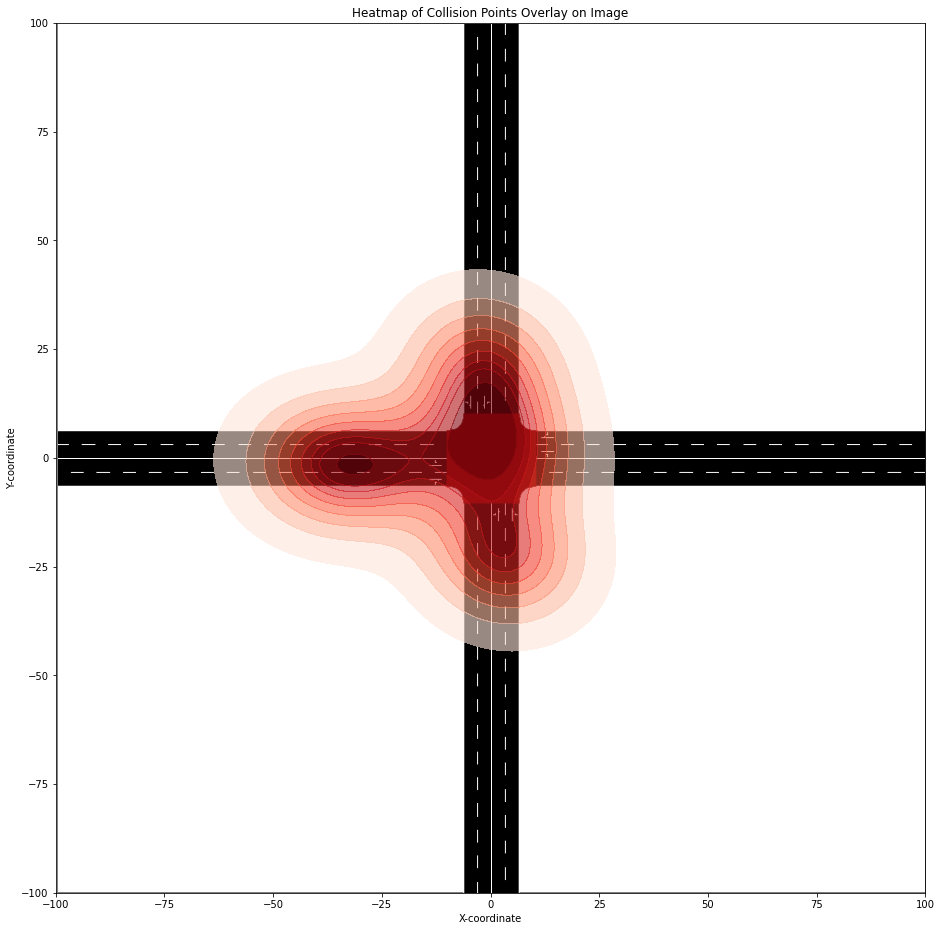

In [6]:
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(new_image, extent=extent_centered)
sns.kdeplot(data=filtered_data, x='x', y='y', fill=True, cmap="Reds", ax=ax, alpha=0.6)
ax.set_title("Heatmap of Collision Points Overlay on Image")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.show()

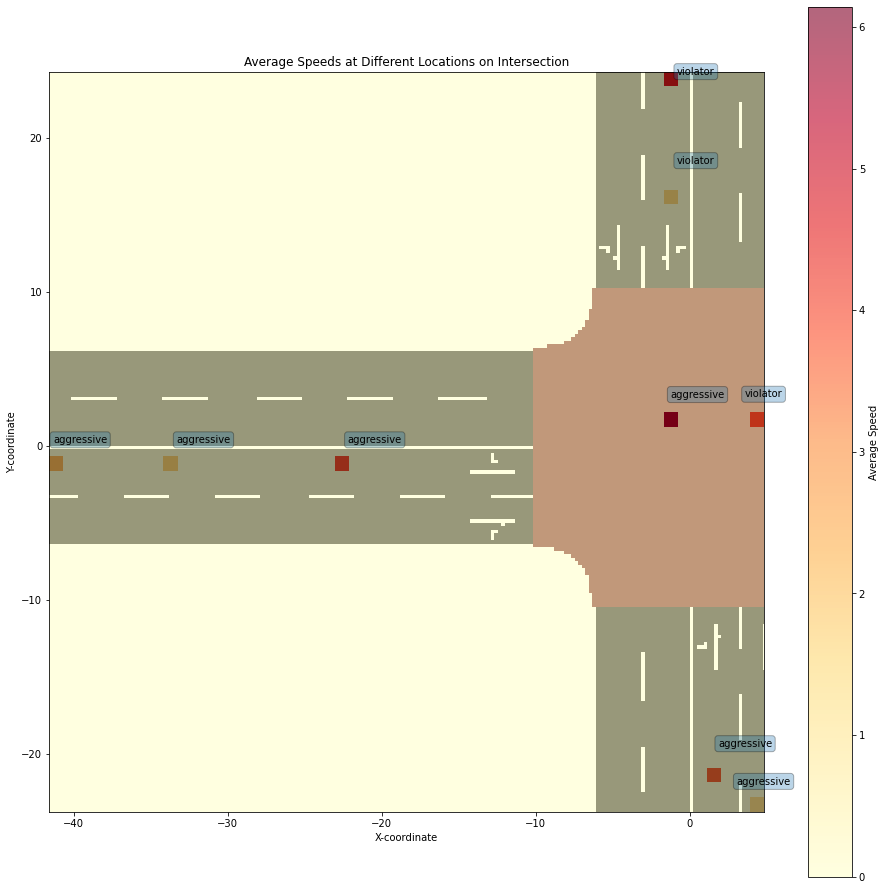

In [7]:
def calculate_average_speeds(df, bins):
    heatmap, xedges, yedges = np.histogram2d(df['x'], df['y'], bins=bins, weights=df['speed'])
    counts, _, _ = np.histogram2d(df['x'], df['y'], bins=bins)
    with np.errstate(divide='ignore', invalid='ignore'):
        average_speeds = np.nan_to_num(heatmap / counts)
    return average_speeds, xedges, yedges

def adjust_text_position(ax, x, y, text, offset=1):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_adj = min(max(x + offset, xlim[0]), xlim[1])
    y_adj = min(max(y + offset, ylim[0]), ylim[1])
    return x_adj, y_adj

bins = [50, 50]
average_speeds, xedges, yedges = calculate_average_speeds(filtered_data, bins)

fig, ax = plt.subplots(figsize=(16,16))

ax.imshow(new_image, extent=extent_centered)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
cax = ax.imshow(average_speeds.T, extent=extent, origin='lower', cmap='YlOrRd', alpha=0.6)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label('Average Speed')

offset = 2 
for index, row in filtered_data.iterrows():
    x_adj, y_adj = adjust_text_position(ax, row['x'], row['y'], row['type'], offset)
    ax.text(x_adj, y_adj, row['type'], color='black', ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round", alpha=0.3))

ax.set_title("Average Speeds at Different Locations on Intersection")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")

plt.show()

### 2. Exploratory Data Analysis (EDA)

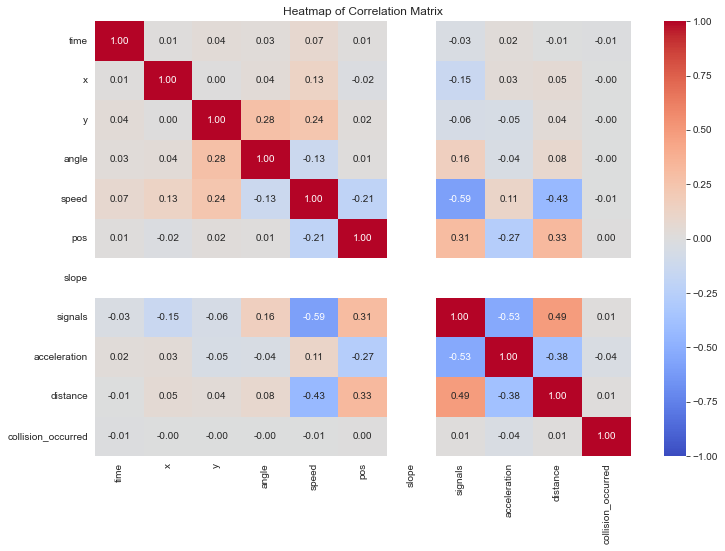

In [18]:
correlation_matrix = dataset_fcd.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

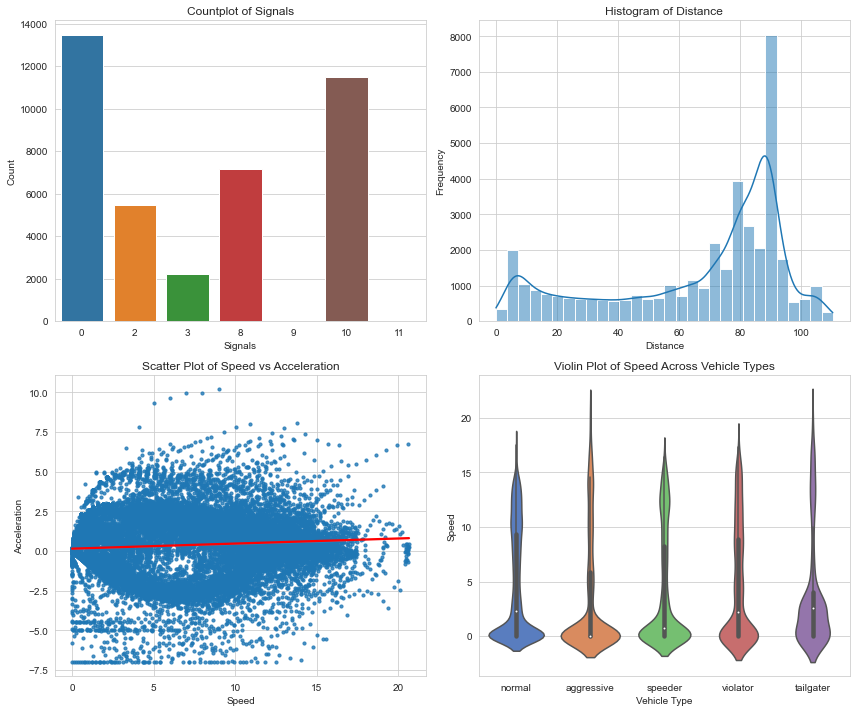

In [25]:
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

if dataset_fcd['signals'].nunique() < 20:  #threshold
    sns.countplot(x='signals', data=dataset_fcd, ax=axs[0, 0])
    axs[0, 0].set_title('Countplot of Signals')
    axs[0, 0].set_xlabel('Signals')
    axs[0, 0].set_ylabel('Count')
else:
    axs[0, 0].axis('off')

# Line Plot of Speed Over Time
sns.histplot(dataset_fcd['distance'], bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Histogram of Distance')
axs[0, 1].set_xlabel('Distance')
axs[0, 1].set_ylabel('Frequency')

# Scatter Plot of Speed vs Acceleration with Linear Regression Line
sns.regplot(x='speed', y='acceleration', data=dataset_fcd, scatter_kws={'s':10}, line_kws={'color':'red'}, ax=axs[1, 0])
axs[1, 0].set_title('Scatter Plot of Speed vs Acceleration')
axs[1, 0].set_xlabel('Speed')
axs[1, 0].set_ylabel('Acceleration')

# Violin Plot of Speed Across Vehicle Types
sns.violinplot(x='type', y='speed', data=dataset_fcd, palette='muted', ax=axs[1, 1])
axs[1, 1].set_title('Violin Plot of Speed Across Vehicle Types')
axs[1, 1].set_xlabel('Vehicle Type')
axs[1, 1].set_ylabel('Speed')

plt.tight_layout()
plt.show()

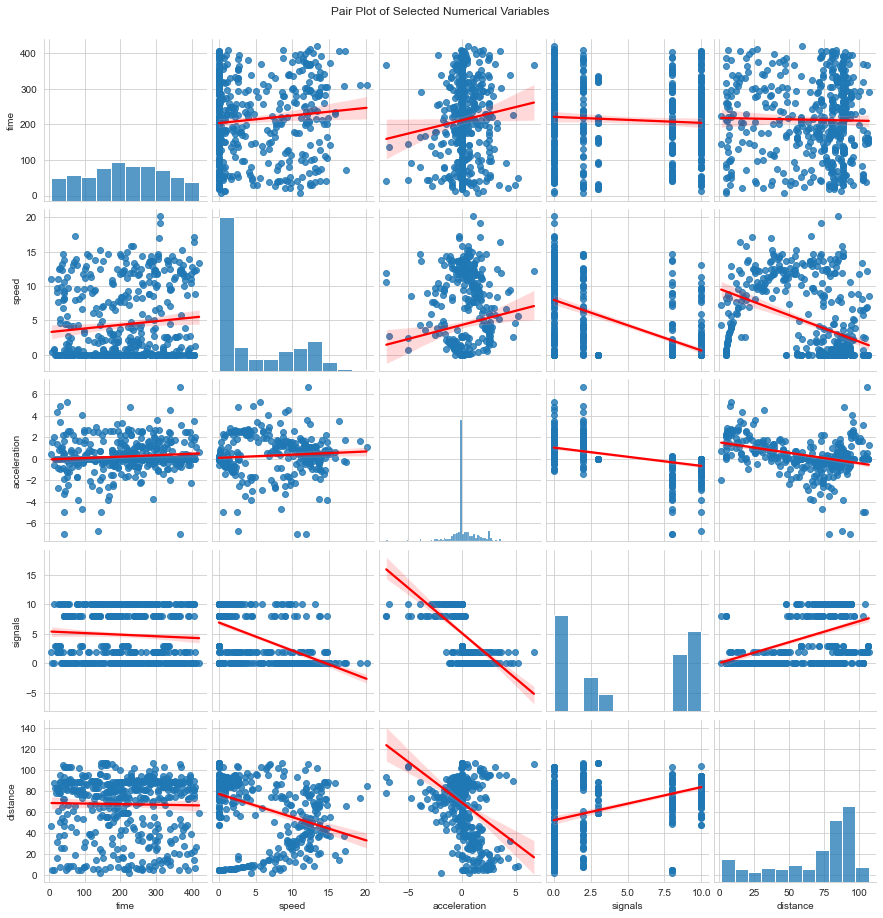

In [32]:
sampled_data = dataset_fcd.sample(n=500, random_state=1)

# Create a pair plot of selected numerical variables
numerical_vars = ['time', 'speed', 'acceleration','signals','distance']
sns.pairplot(sampled_data[numerical_vars],kind='reg',plot_kws={'line_kws': {'color': 'red'}})
plt.suptitle('Pair Plot of Selected Numerical Variables', y=1.02)
plt.show()

What can we do with this dataset?
1. Collision Prediction: Predict the likelihood of a collision occurring based on attributes like speed, distance, and type of vehicle.
2. Anomaly Detection: Identify unusual patterns or outliers in the traffic flow, which could indicate accidents or other irregular events.
3. Type Classification: Classify the type of vehicle based on attributes like speed, acceleration, and lane.
4. Lane Prediction: Predict the lane a vehicle will be in based on its current position, speed, and angle.

### Anomaly Detection

Anomaly Detection Techniques:

1. Statistical Methods: outliers based on statistical properties (IQR).
2. Machine Learning-Based Methods: Isolation Forest, One-Class SVM, Autoencoders.
3. Clustering-Based Methods: K-Means or DBSCAN to identify points that do not belong to any cluster.

### Isolation Forest

In [183]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

In [184]:
# One-Hot Encoding for categorical variables
data_one_hot = pd.get_dummies(dataset_fcd, columns=['type', 'signals'])
features = ['speed', 'acceleration', 'distance']

data_features = data_one_hot[features + list(data_one_hot.columns[14:])]
data_features.head()

,speed,acceleration,distance,type_aggressive,type_normal,type_speeder,type_tailgater,type_violator,signals_0,signals_2,signals_3,signals_8,signals_9,signals_10,signals_11
0,0.00,0.00,5.10,0,1,0,0,0,1,0,0,0,0,0,0
1,0.01,0.15,5.10,0,1,0,0,0,0,0,0,1,0,0,0
2,0.04,0.28,5.11,0,1,0,0,0,0,0,0,1,0,0,0
3,0.09,0.49,5.11,0,1,0,0,0,0,0,0,1,0,0,0
4,0.17,0.81,5.13,0,1,0,0,0,1,0,0,0,0,0,0


In [185]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)

In [193]:
model = IsolationForest(contamination=0.05)  # Set contamination parameter to 5%
model.fit(data_scaled)

IsolationForest(contamination=0.05)

In [194]:
predictions = model.predict(data_scaled) # (1 for normal, -1 for anomaly)
anomalies = np.where(predictions == -1, 1, 0) # binary format (1 for anomaly, 0 for normal)

In [195]:
anom_data = dataset_fcd[list(dataset_fcd.columns[1:])]
anom_data['anomalies_detected'] = anomalies
num_anomalies = anomalies.sum()
anomaly_data = anom_data[anom_data['anomalies_detected'] == 1]

num_anomalies

1989

In [196]:
anomaly_data[anomaly_data['collision_occurred']==1] # 7/1989

,id,x,y,angle,type,speed,pos,lane,slope,signals,acceleration,distance,collision_type,collision_occurred,InvolvedParties,anomalies_detected
394,myflow.2,-22.45,-1.60,90.00,aggressive,3.83,77.55,E0_1,0.0,10,-7.00,77.55,lane,1,collider,1
2180,myflow.8,4.80,1.36,0.00,violator,3.70,11.76,J2_9_0,0.0,8,-2.20,101.36,junction,1,collider,1
5875,myflow.19,-1.60,24.31,180.00,violator,4.60,75.69,E2_1,0.0,10,-5.82,75.69,lane,1,collider,1
6526,myflow.21,4.80,-23.78,0.00,aggressive,1.28,76.22,-E3_0,0.0,8,-6.59,76.22,lane,1,collider,1
11448,myflow.27,-1.49,1.34,62.36,aggressive,6.14,4.56,J2_19_0,0.0,2,5.09,99.17,junction,1,collider,1
29607,myflow.75,-33.57,-1.60,90.00,aggressive,1.62,66.43,E0_1,0.0,10,-6.99,66.43,lane,1,collider,1
31105,myflow.78,-1.60,16.53,180.00,violator,1.49,83.47,E2_1,0.0,10,-6.99,83.47,lane,1,collider,1


### DBSCAN Clustering

In [199]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data_scaled)

anomalies_dbscan = (clusters == -1).astype(int) # binary format (1 for anomaly, 0 for normal)

anom_data['cluster'] = clusters
anom_data['anomaly_dbscan'] = anomalies_dbscan

num_anomalies_dbscan = anomalies_dbscan.sum()
anomaly_data_dbscan = anom_data[anom_data['anomaly_dbscan'] == 1]
num_anomalies_dbscan

122

In [200]:
anomaly_data_dbscan[anomaly_data_dbscan['collision_occurred']==1] # 4/122

,id,x,y,angle,type,speed,pos,lane,slope,signals,acceleration,distance,collision_type,collision_occurred,InvolvedParties,anomalies_detected,cluster,anomaly_dbscan
2180,myflow.8,4.80,1.36,0.0,violator,3.70,11.76,J2_9_0,0.0,8,-2.20,101.36,junction,1,collider,1,-1,1
11451,myflow.31,-2.46,1.60,270.0,aggressive,6.39,12.86,J2_5_1,0.0,0,0.51,102.46,junction,1,victim,0,-1,1
13869,myflow.40,1.60,-21.33,0.0,aggressive,3.53,78.67,-E3_1,0.0,8,-3.44,78.67,lane,1,collider,0,-1,1
18299,myflow.49,-41.58,-1.60,90.0,aggressive,2.12,58.42,E0_1,0.0,10,-2.78,58.42,lane,1,collider,0,-1,1
